<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/f-TEP/ClassificadorXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais


<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>

In [1]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install -U pyFTS
!pip3 install SimpSOM
!pip install dispy
#!pip install matplotlib==3.1.3
!pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-0dgz98h7
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-0dgz98h7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simpsom 2.0.1 requires matplotlib>=3.3.3, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Dados TEP

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#importing all the necessary libraries 
!pip install pyreadr
import pandas as pd
import seaborn as sns
import numpy as np
import pyreadr as py # library to read .Rdata files in python
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,BatchNormalization
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score,f1_score
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
from time import time
from scipy.sparse import hstack
from tensorflow.python.keras.callbacks import TensorBoard
import pickle
import datetime
from tensorflow.keras.utils import to_categorical
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#reading train data in .R format
a1 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_FaultFree_Training.RData")
a2 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_Faulty_Training.RData")

#reading test data in .R format

a3 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_FaultFree_Testing.RData")
a4 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_Faulty_Testing (1).RData")

print("Objects that are present in a1 :",a1.keys())
print("Objects that are present in a2 :",a2.keys())
print("Objects that are present in a3 :",a3.keys())
print("Objects that are present in a4 :",a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])
Objects that are present in a3 : odict_keys(['fault_free_testing'])
Objects that are present in a4 : odict_keys(['faulty_testing'])


In [5]:
#REading the .Rdata files in pandas dataframe and saving it in .csv file
#reading train data
b1 = a1['fault_free_training']
b2 = a2['faulty_training']
#reading test data
b3 = a3['fault_free_testing']
b4 = a4['faulty_testing']

# concatinating the train and the test dataset
frames_tr = [b1,b3]
train_ts = pd.concat(frames_tr)
frames_ts = [b2,b4]
test = pd.concat(frames_ts)

In [6]:
print('Shape of the Train dataset:', train_ts.shape)
print("Shape of the Test dataset:", test.shape)

print("Distrubution of faults in train dataset:")
print(train_ts['faultNumber'].value_counts())

print("Distrubution of faults in train dataset:")
print(test['faultNumber'].value_counts())

Shape of the Train dataset: (730000, 55)
Shape of the Test dataset: (14600000, 55)
Distrubution of faults in train dataset:
0.0    730000
Name: faultNumber, dtype: int64
Distrubution of faults in train dataset:
1     730000
2     730000
19    730000
18    730000
17    730000
16    730000
15    730000
14    730000
13    730000
12    730000
11    730000
10    730000
9     730000
8     730000
7     730000
6     730000
5     730000
4     730000
3     730000
20    730000
Name: faultNumber, dtype: int64


In [7]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

In [8]:
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets = {}

dff = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosFalha.xlsx')
dfn = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosNormais.xlsx')

dados_treino_Falha = dff[0:2300] 
dados_teste_Falha = dff[1800:2300]

dados_treino_Normal = dfn[0:1800] 
dados_teste_Normal = dfn[1500:1800]

In [9]:
print(dados_treino_Falha)

                    Data  LIT_2012KS_0251_FilteredSignal  \
0    2021-12-05 08:50:13                       35.298019   
1    2021-12-05 08:51:25                       69.698112   
2    2021-12-05 08:52:37                       86.492775   
3    2021-12-05 08:53:49                       87.605766   
4    2021-12-05 08:55:01                       87.592270   
...                  ...                             ...   
2295 2021-12-09 22:55:01                       39.161282   
2296 2021-12-09 22:56:13                       34.402630   
2297 2021-12-09 22:57:25                       29.267023   
2298 2021-12-09 22:58:37                       24.829168   
2299 2021-12-09 22:59:49                       18.879450   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
0                        0.000000                604.000305   
1                        0.000000                594.372681   
2                        0.000000                548.985413   
3                        0.

In [10]:
print(dados_treino_Normal)

                    Data  LIT_2012KS_0251_FilteredSignal  \
0    2021-12-05 07:20:13                        2.832069   
1    2021-12-05 07:21:25                        4.418116   
2    2021-12-05 07:22:37                       22.953905   
3    2021-12-05 07:23:49                       33.815975   
4    2021-12-05 07:25:01                       33.374435   
...                  ...                             ...   
1795 2021-12-07 02:38:13                       11.774282   
1796 2021-12-07 02:39:25                        4.781181   
1797 2021-12-07 02:40:37                        3.563411   
1798 2021-12-07 02:41:49                        3.671766   
1799 2021-12-07 02:43:01                        3.691521   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
0                        0.000000                295.496826   
1                        0.000000                321.693665   
2                       14.761859                337.279755   
3                       71.

In [11]:
print(dados_teste_Falha)

                    Data  LIT_2012KS_0251_FilteredSignal  \
1800 2021-12-08 22:32:13                       68.584373   
1801 2021-12-08 22:33:25                       79.267204   
1802 2021-12-08 22:34:37                       74.231430   
1803 2021-12-08 22:35:49                       67.143143   
1804 2021-12-08 22:37:01                       56.879524   
...                  ...                             ...   
2295 2021-12-09 22:55:01                       39.161282   
2296 2021-12-09 22:56:13                       34.402630   
2297 2021-12-09 22:57:25                       29.267023   
2298 2021-12-09 22:58:37                       24.829168   
2299 2021-12-09 22:59:49                       18.879450   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
1800                    36.922737                551.704773   
1801                    51.525627                551.704529   
1802                    59.430199                551.716675   
1803                    59.

In [12]:
print(dados_teste_Normal)

                    Data  LIT_2012KS_0251_FilteredSignal  \
1500 2021-12-08 09:28:37                       43.040955   
1501 2021-12-08 09:29:49                       37.851479   
1502 2021-12-08 09:31:01                       32.487022   
1503 2021-12-08 09:32:13                       27.220686   
1504 2021-12-08 09:33:25                       22.106337   
...                  ...                             ...   
1795 2021-12-07 02:38:13                       11.774282   
1796 2021-12-07 02:39:25                        4.781181   
1797 2021-12-07 02:40:37                        3.563411   
1798 2021-12-07 02:41:49                        3.671766   
1799 2021-12-07 02:43:01                        3.691521   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
1500                    59.528919                297.226349   
1501                    59.413948                246.993668   
1502                    59.192154                220.550995   
1503                    59.

## Analisando as Séries Temporais

TypeError: ignored

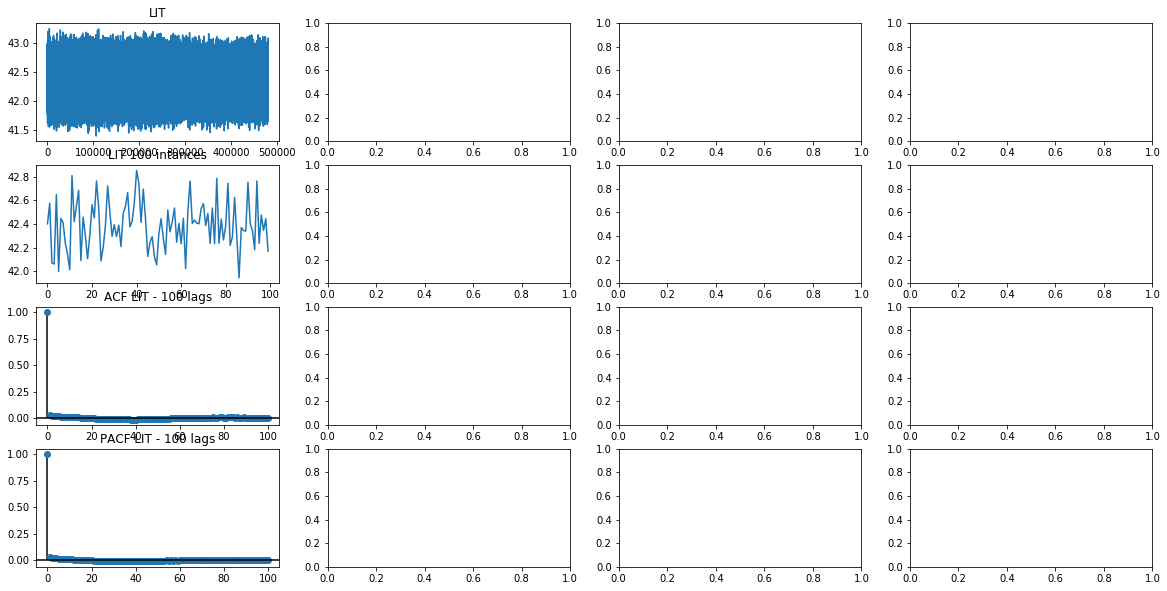

In [13]:
#Dados com Falhas

from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets1 = {}

#datasets1['LIT'] = dados_treino_Falha.get('LIT_2012KS_0251_FilteredSignal')
datasets1['LIT'] = train_ts.get('xmeas_6')
#datasets1['SpeedActual'] = dados_treino_Falha.get('_AL_2012KS_06M1_SpeedActual')
datasets1['SpeedActual'] = dados_treino_Falha.get('xmeas_7')
#datasets1['BeltLoad'] = dados_treino_Falha.get('WIT_1085KS_2300_BeltLoad')
datasets1['BeltLoad'] = dados_treino_Falha.get('xmeas_8')
#datasets1['Rate'] = dados_treino_Falha.get('WIT_1085KS_2300_Rate')
datasets1['Rate'] = dados_treino_Falha.get('xmeas_9')

fig1, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets1.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

In [ ]:
#Dados normais - sem falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets2 = {}

datasets2['LIT'] = dados_treino_Normal.get('LIT_2012KS_0251_FilteredSignal')
datasets2['SpeedActual'] = dados_treino_Normal.get('_AL_2012KS_06M1_SpeedActual')
datasets2['BeltLoad'] = dados_treino_Normal.get('WIT_1085KS_2300_BeltLoad')
datasets2['Rate'] = dados_treino_Normal.get('WIT_1085KS_2300_Rate')


fig2, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets2.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

In [ ]:
#Dados normais - sem falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets3 = {}

datasets3['LIT'] = dados_teste_Normal.get('LIT_2012KS_0251_FilteredSignal')
datasets3['SpeedActual'] = dados_teste_Normal.get('_AL_2012KS_06M1_SpeedActual')
datasets3['BeltLoad'] = dados_teste_Normal.get('WIT_1085KS_2300_BeltLoad')
datasets3['Rate'] = dados_teste_Normal.get('WIT_1085KS_2300_Rate')


fig3, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets3.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

In [ ]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

metodos = [Grid.GridPartitioner, Entropy.EntropyPartitioner, CMeans.CMeansPartitioner ]

k = 30

rows = []

y1=np.asarray(datasets1['SpeedActual'])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y1, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part = metodo(data=y1, npart=k)
  model = hofts.HighOrderFTS(order=2, partitioner=part)
  model.fit(y1)
  forecasts = model.predict(y1)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=part.name)
  
  rmse, mape, u = Measures.get_point_statistics(y1, model)
  
  rows.append([part.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

In [ ]:
#Dados Sem Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets2['LIT']
tam_grupo = 100
i=0
VT1=[]

for i in range(0,y1.size,tam_grupo):
  grpan = y1[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
    model1.fit(np.asarray(y1))  
  #print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VT1 = V1
  else:
    VT1 = np.c_[VT1,V1]

  print(i)

VT1 = np.transpose(VT1)
print(VT1)

In [ ]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets2['SpeedActual']
tam_grupo = 100
i=0
VT2=[]
V2=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(y2))  
  #print(model1)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VT2 = V2
  else:
    VT2 = np.c_[VT2,V2]

  print(i)

VT2 = np.transpose(VT2)
print(VT2)



In [ ]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets2['BeltLoad']
tam_grupo = 100
i=0
VT3=[]
V3=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(y3))  
  #print(model1)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VT3 = V3
  else:
    VT3 = np.c_[VT3,V3]

  print(i)

VT3 = np.transpose(VT3)
print(VT3)

In [ ]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets2['Rate']
tam_grupo = 100
i=0
VT4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  #print(model1)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VT4 = V4
  else:
    VT4 = np.c_[VT4,V4]

  print(i)

VT4 = np.transpose(VT4)
print(VT4)

In [ ]:
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets1['LIT']
tam_grupo = 100
i=0
VU1=[]

for i in range(0,y1.size,tam_grupo):
  grpan = y1[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
    model1.fit(np.asarray(y1))  
  #print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VU1 = V1
  else:
    VU1 = np.c_[VU1,V1]

  print(i)

VU1 = np.transpose(VU1)
print(VU1)

In [ ]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets1['SpeedActual']
tam_grupo = 100
i=0
VU2=[]
V2=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(y2))  
  #print(model1)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VU2 = V2
  else:
    VU2 = np.c_[VU2,V2]

  print(i)

VU2 = np.transpose(VU2)
print(VU2)

In [ ]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets1['BeltLoad']
tam_grupo = 100
i=0
VU3=[]
V3=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(y3))  
  #print(model1)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VU3 = V3
  else:
    VU3 = np.c_[VU3,V3]

  print(i)

VU3 = np.transpose(VU3)
print(VU3)

In [ ]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets1['Rate']
tam_grupo = 100
i=0
VU4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  #print(model1)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VU4 = V4
  else:
    VU4 = np.c_[VU4,V4]

  print(i)

VU4 = np.transpose(VU4)
print(VU4)

In [ ]:
ytst1 = np.ones(198)
ytst2 = np.zeros(253)
ytst = np.concatenate((ytst1,ytst2))

In [ ]:
#Unir todas as matrizes geradas
BaseT1 = np.transpose(np.concatenate([np.transpose(VT1),np.transpose(VT2),np.transpose(VT3),np.transpose(VT4)]))
BaseT2 = np.transpose(np.concatenate([np.transpose(VU1),np.transpose(VU2),np.transpose(VU3),np.transpose(VU4)]))
BaseT3 = np.c_[np.transpose(BaseT1), np.transpose(BaseT2)]
BaseT4 = np.c_[np.transpose(BaseT3),ytst]

In [ ]:
pwfts.visualize_distributions(model1)

In [ ]:
pwfts.visualize_distributions(model2)

In [ ]:
pwfts.visualize_distributions(model3)

In [ ]:
pwfts.visualize_distributions(model4)

In [ ]:
#dataset = pd.read_excel('../content/sample_data/Base.xlsx')
#x = dataset.iloc[:,:-1].values
#y = dataset.iloc[:,-1].values
x = BaseT4[:,:-1]
y = BaseT4[:,-1]

In [ ]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dff.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [ ]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dfn.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size = 0.2, random_state = 10)

In [ ]:
from xgboost import XGBClassifier
Classifier = XGBClassifier()
Classifier.fit(x_train, y_train)

Matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred = Classifier.predict(x_test)
cm = confusion_matrix(y_test, ypred)
print(cm)

Precisão

In [ ]:
accuracy_score(y_test, ypred)

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Classifier, X = x_train, y = y_train, cv = 2)

print(accuracies.mean()*100)
print(accuracies.std()*100)